In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.cluster import KMeans
from datetime import datetime
import uuid

In [2]:
df = pd.read_parquet('processed_orders.parquet')

In [3]:
# Unit Economics
customer_metrics = df.groupby('Код клиента').agg({
    'Сумма, BYN': 'sum',
    'Profit': 'sum',
    'Дата': ['count', 'max']
}).reset_index()
customer_metrics.columns = ['Код клиента', 'Общая выручка', 'Общая прибыль', 'Количество заказов', 'Последняя покупка']
customer_metrics['Средняя прибыль на заказ'] = customer_metrics['Общая прибыль'] / customer_metrics['Количество заказов']

In [4]:
# RFM-анализ
current_date = df['Дата'].max()
customer_metrics['Recency'] = (current_date - customer_metrics['Последняя покупка']).dt.days
customer_metrics['Frequency'] = customer_metrics['Количество заказов']
customer_metrics['Monetary'] = customer_metrics['Общая прибыль']


In [5]:
# Определение RFM-сегментов
quantiles = customer_metrics[['Recency', 'Frequency', 'Monetary']].quantile([0.25, 0.5, 0.75])
def rfm_score(x, metric, quantiles):
    if metric == 'Recency':
        if x <= quantiles[metric][0.25]:
            return 4
        elif x <= quantiles[metric][0.5]:
            return 3
        elif x <= quantiles[metric][0.75]:
            return 2
        else:
            return 1
    else:  # Frequency, Monetary
        if x >= quantiles[metric][0.75]:
            return 4
        elif x >= quantiles[metric][0.5]:
            return 3
        elif x >= quantiles[metric][0.25]:
            return 2
        else:
            return 1

customer_metrics['R_Score'] = customer_metrics['Recency'].apply(rfm_score, args=('Recency', quantiles))
customer_metrics['F_Score'] = customer_metrics['Frequency'].apply(rfm_score, args=('Frequency', quantiles))
customer_metrics['M_Score'] = customer_metrics['Monetary'].apply(rfm_score, args=('Monetary', quantiles))
customer_metrics['RFM_Score'] = customer_metrics['R_Score'] + customer_metrics['F_Score'] + customer_metrics['M_Score']
customer_metrics['RFM_Segment'] = customer_metrics['RFM_Score'].apply(
    lambda x: 'Чемпионы' if x >= 10 else 'Лояльные' if x >= 7 else 'Риск ухода' if x >= 4 else 'Потерянные'
)

In [6]:
# ABC-анализ клиентов
customer_metrics = customer_metrics.sort_values('Общая прибыль', ascending=False)
customer_metrics['Кумулятивная прибыль'] = customer_metrics['Общая прибыль'].cumsum()
total_profit = customer_metrics['Общая прибыль'].sum()
customer_metrics['Процент кумулятивной прибыли'] = customer_metrics['Кумулятивная прибыль'] / total_profit
customer_metrics['ABC'] = pd.cut(
    customer_metrics['Процент кумулятивной прибыли'],
    bins=[0, 0.2, 0.5, 1.0],
    labels=['A', 'B', 'C']
)

In [7]:
# XYZ-анализ клиентов
customer_orders = df.groupby(['Код клиента', 'Month'])['Profit'].sum().reset_index()
cv = customer_orders.groupby('Код клиента')['Profit'].std() / customer_orders.groupby('Код клиента')['Profit'].mean()
customer_metrics = customer_metrics.merge(cv.rename('CV'), on='Код клиента', how='left')
customer_metrics['CV'] = customer_metrics['CV'].fillna(0)
customer_metrics['XYZ'] = pd.cut(
    customer_metrics['CV'],
    bins=[0, 0.25, 0.5, np.inf],
    labels=['X', 'Y', 'Z']
)

In [8]:
customer_metrics.to_csv('/home/roman/PycharmProjects/Dzemidovich_kursovoi/results/customer_segments.csv', index=False)

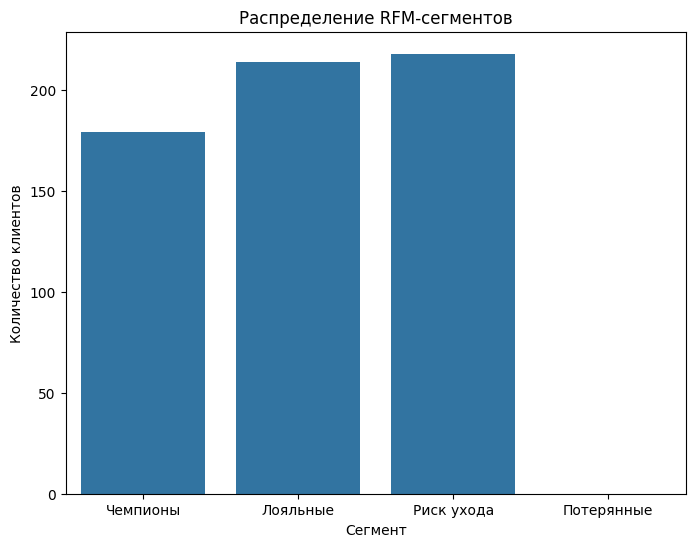

In [9]:
# Гистограмма
plt.figure(figsize=(8, 6))
sns.countplot(data=customer_metrics, x='RFM_Segment', order=['Чемпионы', 'Лояльные', 'Риск ухода', 'Потерянные'])
plt.title('Распределение RFM-сегментов')
plt.xlabel('Сегмент')
plt.ylabel('Количество клиентов')
plt.show()

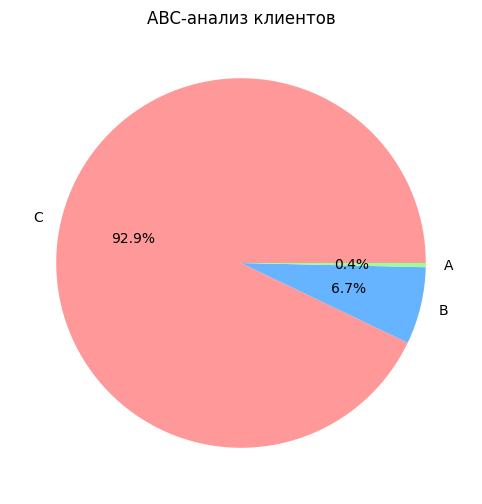

In [10]:
# Круговая диаграмма ABC
plt.figure(figsize=(8, 6))
customer_metrics['ABC'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#ff9999', '#66b3ff', '#99ff99'])
plt.title('ABC-анализ клиентов')
plt.ylabel('')
plt.show()

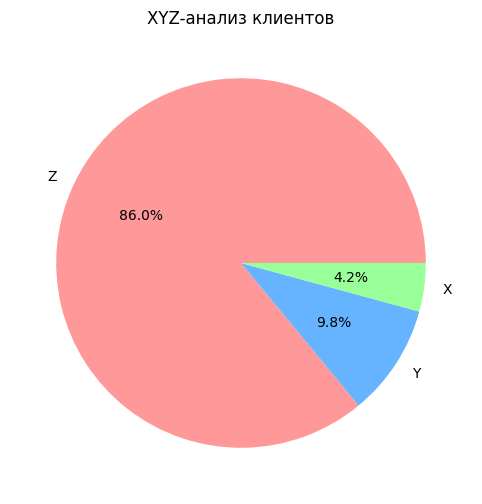

In [11]:
# Круговая диаграмма XYZ
plt.figure(figsize=(8, 6))
customer_metrics['XYZ'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#ff9999', '#66b3ff', '#99ff99'])
plt.title('XYZ-анализ клиентов')
plt.ylabel('')
plt.show()